In [1]:
import os
import numpy as np
import pandas as pd
import torch
import json
from PIL import Image  
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from fastai.learner import Learner
from monai.networks.nets import resnet18
from fastai.data.core import DataLoaders
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
# # Load datasets
# df = pd.read_csv('Final_Datasets/blood_flow_heart.csv')
# df_test = pd.read_csv('Final_Datasets/test_data_incidence.csv')
# controls = pd.read_csv('Final_Datasets/imbalanced_control_iid.csv')

# # Remove test cases and controls
# test_iids = set(df_test['IID'])

# # Get all cases (CAD = 1) from blood_flow_heart.csv, excluding test data
# cases_train = df[(df['CAD'] == 1) & (~df['IID'].isin(test_iids))]

# # Get all controls (IID in controls.csv and CAD = 0), excluding test data
# controls_train = df[(df['IID'].isin(controls['IID'])) & (df['CAD'] == 0) & (~df['IID'].isin(test_iids))]

# # Combine the imbalanced dataset
# df_imbalanced_train = pd.concat([cases_train, controls_train]).reset_index(drop=True)

# # Save the imbalanced dataset
# df_imbalanced_train.to_csv('Final_Datasets/train_imbalanced_blood_flow.csv', sep=',', index=False)

# # Report the dataset statistics
# cases_count = len(cases_train)
# controls_count = len(controls_train)
# print(f"Number of cases: {cases_count}")
# print(f"Number of controls: {controls_count}")
# print(f"Imbalance ratio (controls to cases): {controls_count / cases_count:.2f}")

In [8]:
class NpyDataset(Dataset):
    def __init__(self, dataframe, image_column_name, label_column_name):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: torch.stack([x, x, x], dim=0) if x.size(0) == 18 else x),  # Stack to create 3 channels
            transforms.Resize((112, 112))  # Resize to 112x112
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        npy_path = self.dataframe.loc[idx, self.image_column_name]
        label = self.dataframe.loc[idx, self.label_column_name]
        image = np.load(npy_path)  # Load NPY file (e.g., shape: (30, 200, 200))

        # Access channel and frames specific to blood flow data 
        image = image[6:24, :, :]  # Selecting frames 6 to 23 (to get 18 frames)

        image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
        image = self.transform(image)  # Apply transforms
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return {'image': image, 'label': label, 'path': npy_path}
    


class HeartDiseaseModelBloodFlow:
    def __init__(self, train_df_path, test_df_path, image_column_name, label_column_name, batch_size=32, model_name='blood_flow_model'):
        self.train_df_path = train_df_path
        self.test_df_path = test_df_path
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.batch_size = batch_size
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self._prepare_data()
        self._prepare_model()

    def _prepare_data(self):
        train_df = pd.read_csv(self.train_df_path)
        test_df = pd.read_csv(self.test_df_path)

        self.train_dataset = NpyDataset(train_df, self.image_column_name, self.label_column_name)
        self.test_dataset = NpyDataset(test_df, self.image_column_name, self.label_column_name)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

    def _prepare_model(self):
        self.model = models.video.r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)
        self.model.to(self.device)

        self.learn = Learner(
            DataLoaders(self.train_loader, self.test_loader),
            self.model,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy],
            wd=1e-4,
            cbs=[
                SaveModelCallback(fname=self.model_name, monitor='train_loss'),
                EarlyStoppingCallback(monitor='train_loss', patience=10)
            ]
        ).to_fp16()

    def train(self, epochs=5, lr=1e-5):
        self.learn.fine_tune(epochs, base_lr=lr)

    def extract_embeddings(self, loader):
        self.model.eval()
        embeddings, labels, paths = [], [], []
        with torch.no_grad():
            for batch in loader:
                images = batch['image']
                label_batch = batch['label']
                path_batch = batch['path']
                images = images.to(self.device)
                
                # Pass through the model until the final pooling layer
                x = self.model.stem(images)
                x = self.model.layer1(x)
                x = self.model.layer2(x)
                x = self.model.layer3(x)
                x = self.model.layer4(x)
                x = self.model.avgpool(x)
                x = torch.flatten(x, 1)
                
                embeddings.append(x.cpu().numpy())
                labels.append(label_batch.cpu().numpy())
                paths.extend(path_batch)  # Collecting the paths
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels, paths

    # Updated generate_embeddings_dataframe function
    def generate_embeddings_dataframe(self, embeddings, labels, paths):
        """
        Creates a Pandas DataFrame from embeddings, labels, and image paths.

        Args:
            embeddings (numpy.ndarray): The extracted embeddings.
            labels (numpy.ndarray): The labels corresponding to the embeddings.
            paths (list of str): The image paths.

        Returns:
            pd.DataFrame: A DataFrame with serialized embeddings and metadata.
        """
        # Serialize embeddings as JSON strings for safe CSV storage
        df = pd.DataFrame({
            'image_path': paths,
            'embedding': [json.dumps(emb.tolist()) for emb in embeddings],
            'label': labels
        })
        return df

    # Updated extract_and_save_embeddings function
    def extract_and_save_embeddings(self):
        """
        Extracts embeddings for train and test datasets and saves them as CSV files.

        The embeddings are serialized as JSON strings for robust CSV storage.
        """
        # Extract training embeddings
        train_embeddings, train_labels, train_paths = self.extract_embeddings(self.train_loader)
        train_df = self.generate_embeddings_dataframe(train_embeddings, train_labels, train_paths)

        # Extract test embeddings
        test_embeddings, test_labels, test_paths = self.extract_embeddings(self.test_loader)
        test_df = self.generate_embeddings_dataframe(test_embeddings, test_labels, test_paths)
        
        # Save DataFrames
        train_df.to_csv('train_embeddings_blood_flow_nov_imbalanced.csv', index=False)
        test_df.to_csv('test_embeddings_blood_flow_nov.csv', index=False)

In [9]:
if __name__ == "__main__":
    model = HeartDiseaseModelBloodFlow(
        train_df_path='Final_Datasets/train_imbalanced_blood_flow.csv',  # Updated for blood flow dataset
        test_df_path='Final_Datasets/test_data_incidence.csv',      # Updated for test data
        image_column_name='FilePath_bf',  # Replace with blood flow image path column name
        label_column_name='CAD',          # Replace with blood flow label column name
        model_name='heart_blood_flow'
    )
    # Uncomment the following line if you need to train the model first
    # model.train(epochs=50, lr=1e-5)
    
    # Extract embeddings and save to CSV
    model.extract_and_save_embeddings()

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
emb = pd.read_csv('train_embeddings_blood_flow_nov_imbalanced.csv')
emb['embedding'] = emb['embedding'].apply(lambda x: np.array(json.loads(x)))
emb.head()

,image_path,embedding,label
0,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2925582_2_flow.npy,"[0.18446621298789978, 0.24290607869625092, 0.005790706258267164, 0.5396073460578918, 0.13018396496772766, 0.10206181555986404, 0.32466304302215576, 0.023105161264538765, 0.03217613697052002, 0.5787386894226074, 0.560667872428894, 0.15059927105903625, 1.665165901184082, 0.2950955033302307, 0.0, 0.01441426482051611, 0.08006115257740021, 0.1362387239933014, 0.00411383667960763, 0.007381945848464966, 0.06271012127399445, 0.007518763188272715, 0.09661852568387985, 0.05237533152103424, 0.20928053557872772, 0.25470924377441406, 0.0, 0.3711300790309906, 0.030871357768774033, 1.0637916326522827, 0....",1
1,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/1971148_2_flow.npy,"[0.18467441201210022, 0.24170051515102386, 0.005711414851248264, 0.5382554531097412, 0.12939397990703583, 0.10305923223495483, 0.32538411021232605, 0.023314842954277992, 0.031248588114976883, 0.5797569751739502, 0.5617306232452393, 0.1507047563791275, 1.6676503419876099, 0.29316654801368713, 0.0, 0.014466244727373123, 0.07983212918043137, 0.13653157651424408, 0.0040907119400799274, 0.007373865693807602, 0.062227681279182434, 0.007559744641184807, 0.0962039902806282, 0.05207110941410065, 0.20903538167476654, 0.2542096674442291, 0.0, 0.37111347913742065, 0.030858473852276802, 1.0623099803924...",1
2,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/4022603_2_flow.npy,"[0.18412335216999054, 0.24122168123722076, 0.005723397247493267, 0.5371797680854797, 0.13000580668449402, 0.10327761620283127, 0.32452327013015747, 0.02344488725066185, 0.030721792951226234, 0.579289436340332, 0.5613272786140442, 0.15048463642597198, 1.6694972515106201, 0.29380279779434204, 0.0, 0.014416364952921867, 0.07996224611997604, 0.1366681307554245, 0.004164122045040131, 0.007364161778241396, 0.062383733689785004, 0.007394726388156414, 0.0960366278886795, 0.052339840680360794, 0.20868822932243347, 0.2537573277950287, 0.0, 0.37231725454330444, 0.030875971540808678, 1.061284661293029...",0
3,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2505102_2_flow.npy,"[0.18427270650863647, 0.2419024109840393, 0.005751647520810366, 0.5376583933830261, 0.13015513122081757, 0.10285282135009766, 0.3242059350013733, 0.023359814658761024, 0.031234264373779297, 0.5796689391136169, 0.560994565486908, 0.1504027396440506, 1.6677353382110596, 0.29399946331977844, 0.0, 0.0144428089261055, 0.07998152822256088, 0.13666969537734985, 0.0041609155014157295, 0.007417373824864626, 0.06259757280349731, 0.007456667255610228, 0.09617654979228973, 0.05241890624165535, 0.2089269757270813, 0.253324955701828, 0.0, 0.3714824914932251, 0.030888281762599945, 1.0619434118270874, 0.0...",0
4,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/4904134_2_flow.npy,"[0.1844276487827301, 0.24126014113426208, 0.0057471212930977345, 0.5370320081710815, 0.12977470457553864, 0.10322508215904236, 0.324817031621933, 0.023558950051665306, 0.030873285606503487, 0.5786696076393127, 0.5611044764518738, 0.1504659354686737, 1.668161392211914, 0.29390865564346313, 0.0, 0.014461285434663296, 0.07991969585418701, 0.136555016040802, 0.004143801983445883, 0.007410857826471329, 0.06233350932598114, 0.007529373746365309, 0.09615032374858856, 0.05238528549671173, 0.20860853791236877, 0.254102885723114, 0.0, 0.37196508049964905, 0.030855456367135048, 1.060957431793213, 0.0...",0


In [12]:
len(emb['embedding'][0])

512

**MONAI RESNET**

In [2]:
class NPYDataset(Dataset):
    """
    Custom PyTorch Dataset for loading 3D medical imaging data from .npy files.
    """
    def __init__(self, dataframe, image_column_name, label_column_name):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing the data.
            image_column_name (str): Name of the column containing the image file paths.
            label_column_name (str): Name of the column containing the labels.
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name

        # Transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize((112, 112))  # Resize to 112x112
        ])

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Load and preprocess a single sample.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            dict: Contains the processed image, label, and original file path.
        """
        try:
            npy_path = self.dataframe.loc[idx, self.image_column_name]
            label = self.dataframe.loc[idx, self.label_column_name]

            # Load the 3D array (e.g., shape: [30, 200, 200])
            image = np.load(npy_path)

            # Select exactly 18 frames for the model
            image = image[6:24, :, :]  # Shape: [18, 200, 200]

            # Convert to tensor and add channel dimension
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 18, 200, 200]

            # Resize spatial dimensions (height and width) to 112x112
            image = F.interpolate(image, size=(112, 112), mode='bilinear', align_corners=False)

            # Apply transformations
            image = self.transform(image)

            label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

            return {'image': image, 'label': label, 'path': npy_path}

        except Exception as e:
            raise RuntimeError(f"Error processing file at index {idx}: {e}")



class HeartDiseaseModelBloodFlow:
    def __init__(self, train_df_path, test_df_path, image_column_name, label_column_name, batch_size=32, model_name='heart_ch0_3channel_MONAI_resnet18'):
        self.train_df_path = train_df_path
        self.test_df_path = test_df_path
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.batch_size = batch_size
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self._prepare_data()
        self._load_model()

    def _prepare_data(self):
        train_df = pd.read_csv(self.train_df_path)
        test_df = pd.read_csv(self.test_df_path)

        self.train_dataset = NPYDataset(train_df, self.image_column_name, self.label_column_name)
        self.test_dataset = NPYDataset(test_df, self.image_column_name, self.label_column_name)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

    def _load_model(self):
        # Create an instance of MONAI's ResNet18
        self.model = resnet18(spatial_dims=3, n_input_channels=1, num_classes=2)

        # Initialize FastAI Learner
        self.learn = Learner(
            DataLoaders(self.train_loader, self.test_loader),
            self.model,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy]
        ).to_fp16()

        # Load the fine-tuned model
        self.learn.load(self.model_name)
        self.model = self.learn.model.eval().to(self.device)

    def extract_embeddings(self, loader):
        embeddings, labels, paths = [], [], []
        with torch.no_grad():
            for batch in loader:
                images = batch['image'].to(self.device)
                label_batch = batch['label']
                path_batch = batch['path']
                
                # Extract embeddings from the penultimate layer
                x = self.model.conv1(images)  # Initial convolution
                x = self.model.bn1(x)        # BatchNorm
                x = self.model.maxpool(x)    # Max pooling
                x = self.model.layer1(x)
                x = self.model.layer2(x)
                x = self.model.layer3(x)
                x = self.model.layer4(x)
                x = self.model.avgpool(x)    # Global average pooling
                x = torch.flatten(x, 1)      # Flatten to get embeddings

                embeddings.append(x.cpu().numpy())
                labels.append(label_batch.cpu().numpy())
                paths.extend(path_batch)  # Collecting the paths
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels, paths

     # Updated generate_embeddings_dataframe function
    def generate_embeddings_dataframe(self, embeddings, labels, paths):
        """
        Creates a Pandas DataFrame from embeddings, labels, and image paths.

        Args:
            embeddings (numpy.ndarray): The extracted embeddings.
            labels (numpy.ndarray): The labels corresponding to the embeddings.
            paths (list of str): The image paths.

        Returns:
            pd.DataFrame: A DataFrame with serialized embeddings and metadata.
        """
        # Serialize embeddings as JSON strings for safe CSV storage
        df = pd.DataFrame({
            'image_path': paths,
            'embedding': [json.dumps(emb.tolist()) for emb in embeddings],
            'label': labels
        })
        return df

    # Updated extract_and_save_embeddings function
    def extract_and_save_embeddings(self):
        """
        Extracts embeddings for train and test datasets and saves them as CSV files.

        The embeddings are serialized as JSON strings for robust CSV storage.
        """
        # Extract training embeddings
        train_embeddings, train_labels, train_paths = self.extract_embeddings(self.train_loader)
        train_df = self.generate_embeddings_dataframe(train_embeddings, train_labels, train_paths)

        # Extract test embeddings
        test_embeddings, test_labels, test_paths = self.extract_embeddings(self.test_loader)
        test_df = self.generate_embeddings_dataframe(test_embeddings, test_labels, test_paths)
        
        # Save DataFrames
        train_df.to_csv('train_embeddings_blood_flow_imbalanced_monai.csv', index=False)
        test_df.to_csv('test_embeddings_blood_flow_imbalanced_monai.csv', index=False)

In [3]:
if __name__ == "__main__":
    model = HeartDiseaseModelBloodFlow(
        train_df_path='Final_Datasets/train_imbalanced_blood_flow.csv',
        test_df_path='Final_Datasets/test_data_incidence.csv',
        image_column_name='FilePath_bf',
        label_column_name='CAD',
        model_name='heart_blood_flow_Med3D_resnet18'  # Fine-tuned model name
    )
    
    # Extract embeddings and save to CSV
    model.extract_and_save_embeddings()

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locat

In [5]:
train = pd.read_csv('train_embeddings_blood_flow_imbalanced_monai.csv')
train['embedding'] = train['embedding'].apply(lambda x: np.array(json.loads(x)))
train.head()

,image_path,embedding,label
0,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/1642190_2_flow.npy,"[0.6947618722915649, 1.4202600717544556, 0.6967049837112427, 0.9921771287918091, 0.9676676988601685, 1.7221970558166504, 0.5753217339515686, 0.667648196220398, 0.9578095078468323, 1.022106409072876, 0.5468735098838806, 0.6066002249717712, 1.3592519760131836, 1.0051463842391968, 0.776728630065918, 0.6976783871650696, 1.1395939588546753, 0.9093515872955322, 0.7117903232574463, 1.1170705556869507, 1.4588186740875244, 1.3645542860031128, 0.5307546257972717, 1.3485969305038452, 1.316362977027893, 1.106878399848938, 0.910477340221405, 1.356172800064087, 1.0661437511444092, 0.6632577180862427, 0....",0
1,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/3259474_2_flow.npy,"[0.5132411122322083, 1.729156732559204, 0.7444906830787659, 1.4157923460006714, 1.1229362487792969, 1.5937409400939941, 0.9863731265068054, 0.5328490734100342, 1.1359386444091797, 1.0210283994674683, 0.4278568923473358, 0.8787835240364075, 1.4920896291732788, 1.0200176239013672, 0.7224335670471191, 0.8723978400230408, 1.232506513595581, 1.2226773500442505, 0.6646676063537598, 1.2407608032226562, 1.6823396682739258, 1.4282951354980469, 1.0184834003448486, 1.2699453830718994, 1.357485055923462, 1.2335859537124634, 0.658989429473877, 1.9014005661010742, 1.4363079071044922, 0.781143844127655, ...",0
2,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/4028626_2_flow.npy,"[0.6034924387931824, 1.744145154953003, 0.9753575325012207, 1.348523497581482, 1.152808666229248, 1.8011283874511719, 0.933570146560669, 0.6956784129142761, 1.276605486869812, 1.164866328239441, 0.43108993768692017, 0.817958414554596, 1.5736976861953735, 0.9254698753356934, 0.6844032406806946, 0.8985008597373962, 1.2254613637924194, 1.207305908203125, 0.5984373688697815, 1.2286772727966309, 1.9381349086761475, 1.4028029441833496, 0.802600085735321, 1.4953452348709106, 1.5621765851974487, 1.208185076713562, 0.6583158373832703, 1.6960647106170654, 1.6324642896652222, 0.8831813335418701, 1.23...",0
3,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2613106_2_flow.npy,"[0.5624148845672607, 1.8594764471054077, 0.9384656548500061, 1.5094835758209229, 1.1882585287094116, 2.11130428314209, 1.0262401103973389, 0.6339626908302307, 1.233359456062317, 1.321002721786499, 0.5119953155517578, 0.7754141688346863, 1.5255188941955566, 1.1365572214126587, 0.7113821506500244, 0.9966295957565308, 1.2500231266021729, 1.210307240486145, 0.6644729375839233, 1.508821725845337, 1.9823228120803833, 1.748808741569519, 0.8583539128303528, 1.6486430168151855, 1.6854634284973145, 1.258876085281372, 0.7322251796722412, 1.9769700765609741, 1.6362286806106567, 0.7401874661445618, 1.1...",0
4,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/1483806_2_flow.npy,"[0.834717869758606, 1.0795385837554932, 0.7549731731414795, 0.6751900911331177, 1.0307645797729492, 1.096537470817566, 0.5277838110923767, 0.6439292430877686, 0.7314755916595459, 1.0013988018035889, 0.6068211793899536, 0.5426034331321716, 0.8330239057540894, 0.8270732760429382, 0.5830716490745544, 0.6863976716995239, 1.224541187286377, 1.0336124897003174, 0.9336428046226501, 0.7481863498687744, 1.0030431747436523, 0.7562724947929382, 0.4969788193702698, 1.0959289073944092, 0.9362773299217224, 0.8633784055709839, 0.6170608401298523, 1.0774954557418823, 0.828561007976532, 0.3664882481098175,...",0


In [6]:
test = pd.read_csv('test_embeddings_blood_flow_imbalanced_monai.csv')
test['embedding'] = test['embedding'].apply(lambda x: np.array(json.loads(x)))
test.head()

,image_path,embedding,label
0,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/4890586_2_flow.npy,"[0.6833826303482056, 1.6826467514038086, 1.1558425426483154, 1.3811225891113281, 0.9882668256759644, 1.5736467838287354, 1.1627744436264038, 1.0413334369659424, 1.1849753856658936, 1.2670270204544067, 0.5287546515464783, 0.967639684677124, 1.2234472036361694, 1.0747182369232178, 1.0187768936157227, 0.9322103261947632, 1.15635085105896, 0.89579176902771, 0.7631632089614868, 1.530327320098877, 1.9005281925201416, 1.6080536842346191, 1.021823525428772, 1.2752702236175537, 1.3381744623184204, 1.228866457939148, 0.7542374730110168, 1.9252749681472778, 1.5670617818832397, 1.0628222227096558, 1.0...",0
1,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2201189_2_flow.npy,"[0.6690220832824707, 1.3973817825317383, 1.1210670471191406, 1.0670486688613892, 0.8931682705879211, 1.2216343879699707, 1.0162349939346313, 0.884547233581543, 0.8911158442497253, 0.9615679979324341, 0.7361097931861877, 0.8373317718505859, 0.8912506103515625, 0.9315395355224609, 0.6835813522338867, 1.072800874710083, 0.7418818473815918, 0.7827321290969849, 0.9077900052070618, 1.294395089149475, 1.365038514137268, 1.1730321645736694, 0.9784991145133972, 0.8439721465110779, 0.9365797638893127, 1.1704515218734741, 0.7635686993598938, 1.3643076419830322, 1.4376516342163086, 0.999579906463623, ...",0
2,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/3646967_2_flow.npy,"[0.539034903049469, 1.6345493793487549, 1.255646824836731, 1.218929648399353, 1.049386739730835, 1.2574889659881592, 1.2267695665359497, 0.7590746283531189, 1.0766968727111816, 1.1968653202056885, 0.5599164366722107, 0.8745685815811157, 1.1250331401824951, 0.7746930718421936, 0.6885402202606201, 1.1526963710784912, 1.2865605354309082, 1.0608760118484497, 0.9433995485305786, 1.272064447402954, 1.632681965827942, 1.495320200920105, 1.1065673828125, 1.0046848058700562, 1.4903509616851807, 1.2528607845306396, 0.7296072244644165, 1.8077607154846191, 1.4808284044265747, 0.9984540343284607, 1.132...",1
3,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2032754_2_flow.npy,"[0.49320709705352783, 2.03706955909729, 1.3409593105316162, 1.732556939125061, 1.1549079418182373, 1.6979860067367554, 1.3819999694824219, 0.8458377718925476, 1.2259061336517334, 1.33035147190094, 0.5317891836166382, 1.1790099143981934, 1.4253329038619995, 1.0717417001724243, 0.8519705533981323, 1.021126627922058, 1.171844720840454, 1.0502392053604126, 0.7857856750488281, 1.9384013414382935, 2.2778244018554688, 2.0543527603149414, 1.1835241317749023, 0.9851729273796082, 1.4211430549621582, 1.3681609630584717, 0.690355658531189, 2.6773741245269775, 2.413511276245117, 1.1016660928726196, 1.2...",0
4,/scratch/07880/devansh/CAD/FID20213_blood_flow/flow/2434644_2_flow.npy,"[0.6274088621139526, 1.3032548427581787, 0.985353410243988, 1.1011772155761719, 0.962912380695343, 1.1943293809890747, 0.8665834069252014, 0.717229425907135, 1.0196082592010498, 0.9896833300590515, 0.5981281995773315, 0.7361879944801331, 1.0648707151412964, 0.807624340057373, 0.6664666533470154, 0.8799201846122742, 0.951754629611969, 1.0290888547897339, 0.8825417757034302, 0.9598280191421509, 1.302996039390564, 1.0787338018417358, 0.8367630243301392, 1.0651805400848389, 1.1156986951828003, 1.03341543674469, 0.6454224586486816, 1.4065252542495728, 1.2846418619155884, 0.6090566515922546, 1.0...",1


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is depr

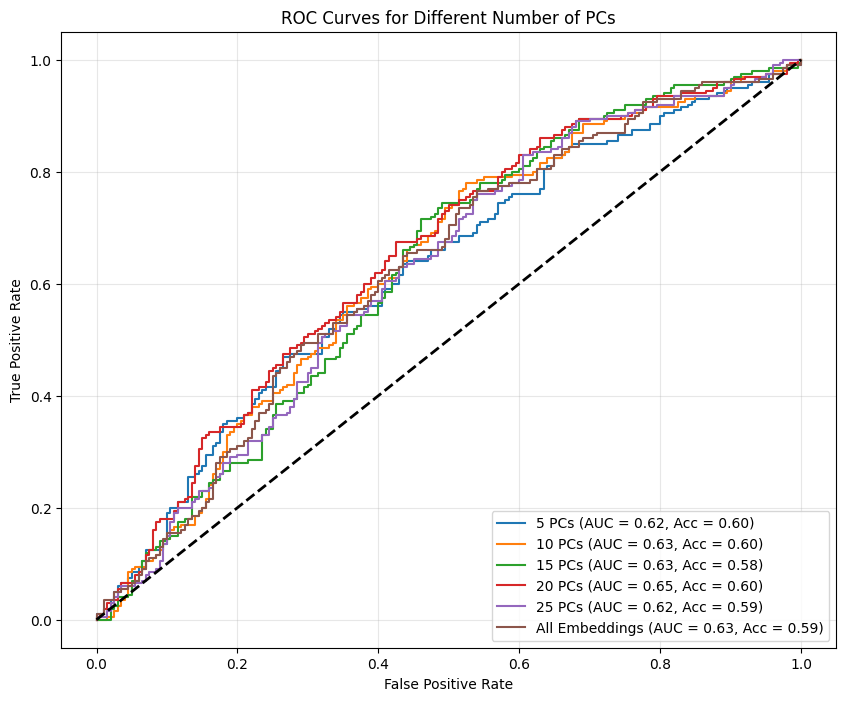

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Assuming train and test dataframes are named 'train' and 'test'
# Expand embeddings into separate columns for train and test
embedding_columns = [f'embedding_{i}' for i in range(len(train['embedding'][0]))]
train_embedding_df = pd.DataFrame(train['embedding'].tolist(), columns=embedding_columns)
train_data = pd.concat([train_embedding_df, train['label']], axis=1)

test_embedding_df = pd.DataFrame(test['embedding'].tolist(), columns=embedding_columns)
test_data = pd.concat([test_embedding_df, test['label']], axis=1)

# Balance the training data
cases = train_data[train_data['label'] == 1]
controls = train_data[train_data['label'] == 0]
min_size = min(len(cases), len(controls))
cases_balanced = cases.sample(n=min_size, random_state=42)
controls_balanced = controls.sample(n=min_size, random_state=42)
balanced_train_data = pd.concat([cases_balanced, controls_balanced])

# Define features and target
X_train = balanced_train_data[embedding_columns]
y_train = balanced_train_data['label']
X_test = test_data[embedding_columns]
y_test = test_data['label']

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of PCs to use
pcs_to_use = [5, 10, 15, 20, 25, len(embedding_columns)]
# Dictionary to store ROC data and accuracy
roc_data = {}

# Train models and evaluate
for num_pcs in pcs_to_use:
    if num_pcs == len(embedding_columns):
        X_train_selected = X_train
        X_test_selected = X_test
    else:
        X_train_selected = X_train_pca[:, :num_pcs]
        X_test_selected = X_test_pca[:, :num_pcs]
    
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Store data
    roc_data[num_pcs] = (fpr, tpr, auc, accuracy)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for num_pcs, (fpr, tpr, auc, accuracy) in roc_data.items():
    label = (
        f"{num_pcs} PCs (AUC = {auc:.2f}, Acc = {accuracy:.2f})"
        if num_pcs != len(embedding_columns)
        else f"All Embeddings (AUC = {auc:.2f}, Acc = {accuracy:.2f})"
    )
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curves for Different Number of PCs")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()